# __DSN Bootcamp Qualification Hackathon 2020__
___

## Import the Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss

from sklearn.svm import SVC
from sklearn import ensemble
import xgboost as xgb
import catboost as cat
import lightgbm as lgb

C:\Users\Sulaimam\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Sulaimam\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\Sulaimam\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
C:\Users\Sulaimam\Anaconda3\lib\site-packages\distributed\utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [WinError 10065] A socket operation was attempted to an unreachable host
  % (

In [2]:
sample_sub = pd.read_csv('SampleSubmission.csv')
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [3]:
sample_sub.shape, train.shape, test.shape

((24000, 2), (56000, 52), (24000, 51))

## Pre-processing
___

In [4]:
def pre_process(df): 
    
#   create dummy columns for the categorical variable: form_field47

    dummy_df = pd.get_dummies(df['form_field47'], prefix='form_field47')
    df = pd.concat([df, dummy_df], axis=1)
    
#   encode the categorical column
    
    df['form_field47'] = LabelEncoder().fit_transform(df['form_field47'])
    df = df.fillna(-99)
    
    df.drop('form_field47_charge', axis=1, inplace=True)
    
    return df

## Feature Engineering
___

In [5]:
def new_features(df):
    df['nf1'] = df['form_field1'] / df['form_field42']
    df['nf2'] = df['form_field1'] * df['form_field2']
    df['nf3'] = df['form_field2'] + df['form_field42']

    return df

In [6]:
train = pre_process(train)
test = pre_process(test)

In [7]:
train = new_features(train)
test = new_features(test)

In [8]:
mapping = {'yes':1, 'no':0}
train['default_status'] = train['default_status'].map(mapping)

In [9]:
train.shape, test.shape

((56000, 56), (24000, 55))

# Helper Function
___

Here, I defined the necessary classes and functions to train the data using a 15-fold Stratified Cross-Validation Technique.
I am using three different algorithms to train the data, namely: `catboost`, `xgboost`, and `lgbm`.

In [10]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm'), 'Incorrect model_type'
    def __call__(self, plot=True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(x_train, x_test, y_train, y_test):
            self.model.fit(x_train, y_train, eval_set=[(x_test,y_test)], early_stopping_rounds=500,
                           verbose=200, use_best_model=True)
            y_train_pred = self.model.predict_proba(x_train)[:,1]
            y_test_pred = self.model.predict_proba(x_test)[:,1]
            self.val_p[test_index] = y_test_pred
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return y_train_pred, y_test_pred

        def xgboost_fit(x_train, x_test, y_train, y_test):
            self.model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=30,
                           eval_metric="auc", verbose=True)
            y_train_pred = self.model.predict_proba(x_train, ntree_limit=self.model.get_booster().best_ntree_limit)[:,1]
            y_test_pred = self.model.predict_proba(x_test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,1]
            self.val_p[test_index] = y_test_pred
            self.test_p += self.model.predict_proba(self.test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,1]
            return y_train_pred, y_test_pred

        def lgbm_fit(x_train, x_test, y_train, y_test):
            self.model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=30,
                           eval_metric="auc", verbose=True)
            y_train_pred = self.model.predict_proba(x_train, num_iteration=self.model.best_iteration_)[:,1]
            y_test_pred = self.model.predict_proba(x_test, num_iteration=self.model.best_iteration_)[:,1]
            self.val_p[test_index] = y_test_pred
            self.test_p += self.model.predict_proba(self.test, num_iteration=self.model.best_iteration_)[:,1]
            return y_train_pred, y_test_pred
        
        def adaboost_fit(x_train, x_test, y_train, y_test):
            self.model.fit(x_train, y_train)
            y_train_pred = self.model.predict_proba(x_train, num_iteration=self.model.best_iteration_)[:,1]
            y_test_pred = self.model.predict_proba(x_test, num_iteration=self.model.best_iteration_)[:,1]
            self.val_p[test_index] = y_test_pred
            self.test_p += self.model.predict_proba(self.test, num_iteration=self.model.best_iteration_)[:,1]
            return y_train_pred, y_test_pred


        self.val_p = np.zeros(self.train.shape[0])
        self.test_p = np.zeros(self.test.shape[0])
        roc_scores_val = list()
        roc_scores_train = list()
        
        skfold = StratifiedKFold(n_splits=15, random_state=seed, shuffle=True)
        splits = skfold.n_splits
        
        for fold_count, (train_index, test_index) in enumerate(skfold.split(self.train, self.label), 1):
            x_train, x_test = self.train.iloc[train_index], self.train.iloc[test_index]
            y_train, y_test = self.label.iloc[train_index], self.label.iloc[test_index]

            print(f"================================Fold{fold_count}====================================")
            
            if self.model_type == 'catboost':
                y_train_pred, y_test_pred = catboost_fit(x_train, x_test, y_train, y_test)
            elif self.model_type == 'xgboost':
                y_train_pred, y_test_pred = xgboost_fit(x_train, x_test, y_train, y_test)
            elif self.model_type == 'lgbm':
                y_train_pred, y_test_pred = lgbm_fit(x_train, x_test, y_train, y_test)
            elif self.model_type == 'adaboost':
                y_train_pred, y_test_pred = adaboost_fit(x_train, x_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, y_test_pred), log_loss(y_test, y_test_pred))
            print('Training scores', roc_auc_score(y_train, y_train_pred), log_loss(y_train, y_train_pred))
            
            roc_scores_val.append(roc_auc_score(y_test, y_test_pred))
            roc_scores_train.append(roc_auc_score(y_train, y_train_pred))

        print(np.mean(roc_scores_val), np.mean(roc_scores_train), np.std(roc_scores_val))

        return self.val_p, self.test_p/splits, self.model

# Model Training

In [11]:
x = train.drop(['Applicant_ID', 'default_status'], axis=1)
y = train['default_status']

seed = 1900

In [12]:
test = test.drop('Applicant_ID', axis=1)

In [13]:
x.shape, y.shape, test.shape

((56000, 54), (56000,), (24000, 54))

### Catboost

In [14]:
catboost = cat.CatBoostClassifier(use_best_model=True, random_seed=seed, silent=True,
                                  early_stopping_rounds=200, n_estimators=5000,
                                  learning_rate=0.01, rsm=0.7, eval_metric='AUC')

In [15]:
cat_predictor = func(x, y, test, catboost, 'catboost', random_state=seed)
cat_val, cat_test, cat_model = cat_predictor()

================================Fold1====================================
0:	test: 0.7951289	best: 0.7951289 (0)	total: 80.6ms	remaining: 6m 43s
200:	test: 0.8283761	best: 0.8283761 (200)	total: 5.6s	remaining: 2m 13s
400:	test: 0.8335183	best: 0.8335272 (398)	total: 11.1s	remaining: 2m 7s
600:	test: 0.8357777	best: 0.8357777 (600)	total: 16.6s	remaining: 2m 1s
800:	test: 0.8371090	best: 0.8371180 (798)	total: 22.1s	remaining: 1m 55s
1000:	test: 0.8378685	best: 0.8378685 (1000)	total: 27.4s	remaining: 1m 49s
1200:	test: 0.8384952	best: 0.8384987 (1197)	total: 32.7s	remaining: 1m 43s
1400:	test: 0.8390345	best: 0.8390345 (1400)	total: 38s	remaining: 1m 37s
1600:	test: 0.8393629	best: 0.8393629 (1600)	total: 44.3s	remaining: 1m 33s
1800:	test: 0.8395098	best: 0.8395245 (1788)	total: 50.1s	remaining: 1m 28s
2000:	test: 0.8398211	best: 0.8398541 (1979)	total: 55.4s	remaining: 1m 23s
2200:	test: 0.8398502	best: 0.8398983 (2164)	total: 1m	remaining: 1m 17s
2400:	test: 0.8398258	best: 0.83995

### XGBoost

In [16]:
xgboost = xgb.XGBClassifier(objective='binary:logistic', eta=0.99, max_depth=6,
                            n_estimators=5000, reg_lambda=500, sub_sample=0.8,
                            colsample_bytree=0.8, random_state=seed)

In [17]:
xgb_predictor = func(x, y, test, xgboost, 'xgboost', random_state=seed)
xgb_val, xgb_test, xgb_model = xgb_predictor()

================================Fold1====================================
[19:42:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.73953
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.80080
[2]	validation_0-auc:0.81111
[3]	validation_0-auc:0.81819
[4]	validation_0-auc:0.82315
[5]	validation_0-auc:0.82504
[6]	validation_0-auc:0.82544
[7]	validation_0-auc:0.82486
[8]	validation_0-auc:0.82623
[9]	validation_0-auc:0.82685
[10]	validation_0-auc:0.82794
[11]	validation_0-auc:0.82885
[12]	validation_0-auc:0.82859
[13]	validation_0-auc:0.82942
[14]	validation_0-auc:0.82923
[15]	validation_0-auc:0.82947
[16]

### LGBM

In [18]:
lgb_model = lgb.LGBMClassifier(objective='binary', metric='auc', boosting_type='gbdt',
                               lambda_l1=0.0004912993970392775, lambda_l2=9.424350138808432,
                               num_leaves=64, feature_fraction=1.0, bagging_fraction=0.9540416539312312,
                               bagging_freq=7, min_child_samples=100, n_estimators=5000, random_state=seed)



In [19]:
lgb_predictor = func(x, y, test, lgb_model, 'lgbm', random_state=seed)
lgb_val, lgb_test, lgb_model = lgb_predictor()

================================Fold1====================================
[1]	valid_0's auc: 0.804056
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.809698
[3]	valid_0's auc: 0.813345
[4]	valid_0's auc: 0.815296
[5]	valid_0's auc: 0.817613
[6]	valid_0's auc: 0.817824
[7]	valid_0's auc: 0.819746
[8]	valid_0's auc: 0.821353
[9]	valid_0's auc: 0.822386
[10]	valid_0's auc: 0.823302
[11]	valid_0's auc: 0.824323
[12]	valid_0's auc: 0.825006
[13]	valid_0's auc: 0.825626
[14]	valid_0's auc: 0.825976
[15]	valid_0's auc: 0.826442
[16]	valid_0's auc: 0.826773
[17]	valid_0's auc: 0.827486
[18]	valid_0's auc: 0.828423
[19]	valid_0's auc: 0.828748
[20]	valid_0's auc: 0.829004
[21]	valid_0's auc: 0.830119
[22]	valid_0's auc: 0.830585
[23]	valid_0's auc: 0.831098
[24]	valid_0's auc: 0.831717
[25]	valid_0's auc: 0.832388
[26]	valid_0's auc: 0.832493
[27]	valid_0's auc: 0.832573
[28]	valid_0's auc: 0.832827
[29]	valid_0's auc: 0.83287
[30]	valid_0's auc: 0.833222
[31]	

# Stacking
___
In order to generate more accurate predictions, I employed Model Stacking, an efficient ensemble method in which I will combined predictions made by 3 algorithms and used as inputs in a second-layer learning algorithm (in this case, Linear Regression).

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor

val_stack = np.column_stack((cat_val, xgb_val, lgb_val))
test_stack = np.column_stack((cat_test, xgb_test, lgb_test))

In [21]:
lr = LinearRegression()

In [22]:
lr.fit(val_stack, y)

LinearRegression()

In [23]:
lr_stack_pred = lr.predict(test_stack)

In [24]:
test_id = sample_sub['Applicant_ID']

stack_df = pd.DataFrame({'Applicant_ID':test_id, 'default_status':lr_stack_pred})

stack_df.to_csv('lr_stack3.csv', index=False)

In [25]:
stack_df

,Applicant_ID,default_status
0,Apcnt_1000032,0.316983
1,Apcnt_1000048,0.382314
2,Apcnt_1000052,0.423675
3,Apcnt_1000076,0.756831
4,Apcnt_1000080,0.170834
...,...,...
23995,Apcnt_999940,0.707066
23996,Apcnt_999956,0.281770
23997,Apcnt_999976,0.269371
23998,Apcnt_999984,0.530280


The following dataframe `df1` is created from the csv file `0.844668_sub.csv`. I filled the null values with -0.1, and got that an AUC score of 0.844668. 
I then decided to blend it with the new predicition, i.e where I filled null values with -99.

In [26]:
df1 = pd.read_csv('0.844668_sub.csv')
# df2 = pd.read_csv('0.844607_sub.csv')
df3 = stack_df.copy()

In [27]:
sr1 = df1['default_status']
# sr2 = df2['default_status']
sr3 = df3['default_status']

In [29]:
blend1 = sr1*0.1 + sr3*0.9

In [30]:
blend_df1 = pd.DataFrame({'Applicant_ID':test_id, 'default_status':blend1})
blend_df1.to_csv('blend3.csv', index=False)

## Plotting of Feature Importance by the Different Algorithms

In [31]:
def plot(model, model_name):
    feat_imp = pd.DataFrame(sorted(zip(model.feature_importances_, x.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(30,20))
    sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
    plt.ylabel('Features')
    plt.title('Feature Importance Score for {}'.format(model_name), fontsize=15)
    plt.show()

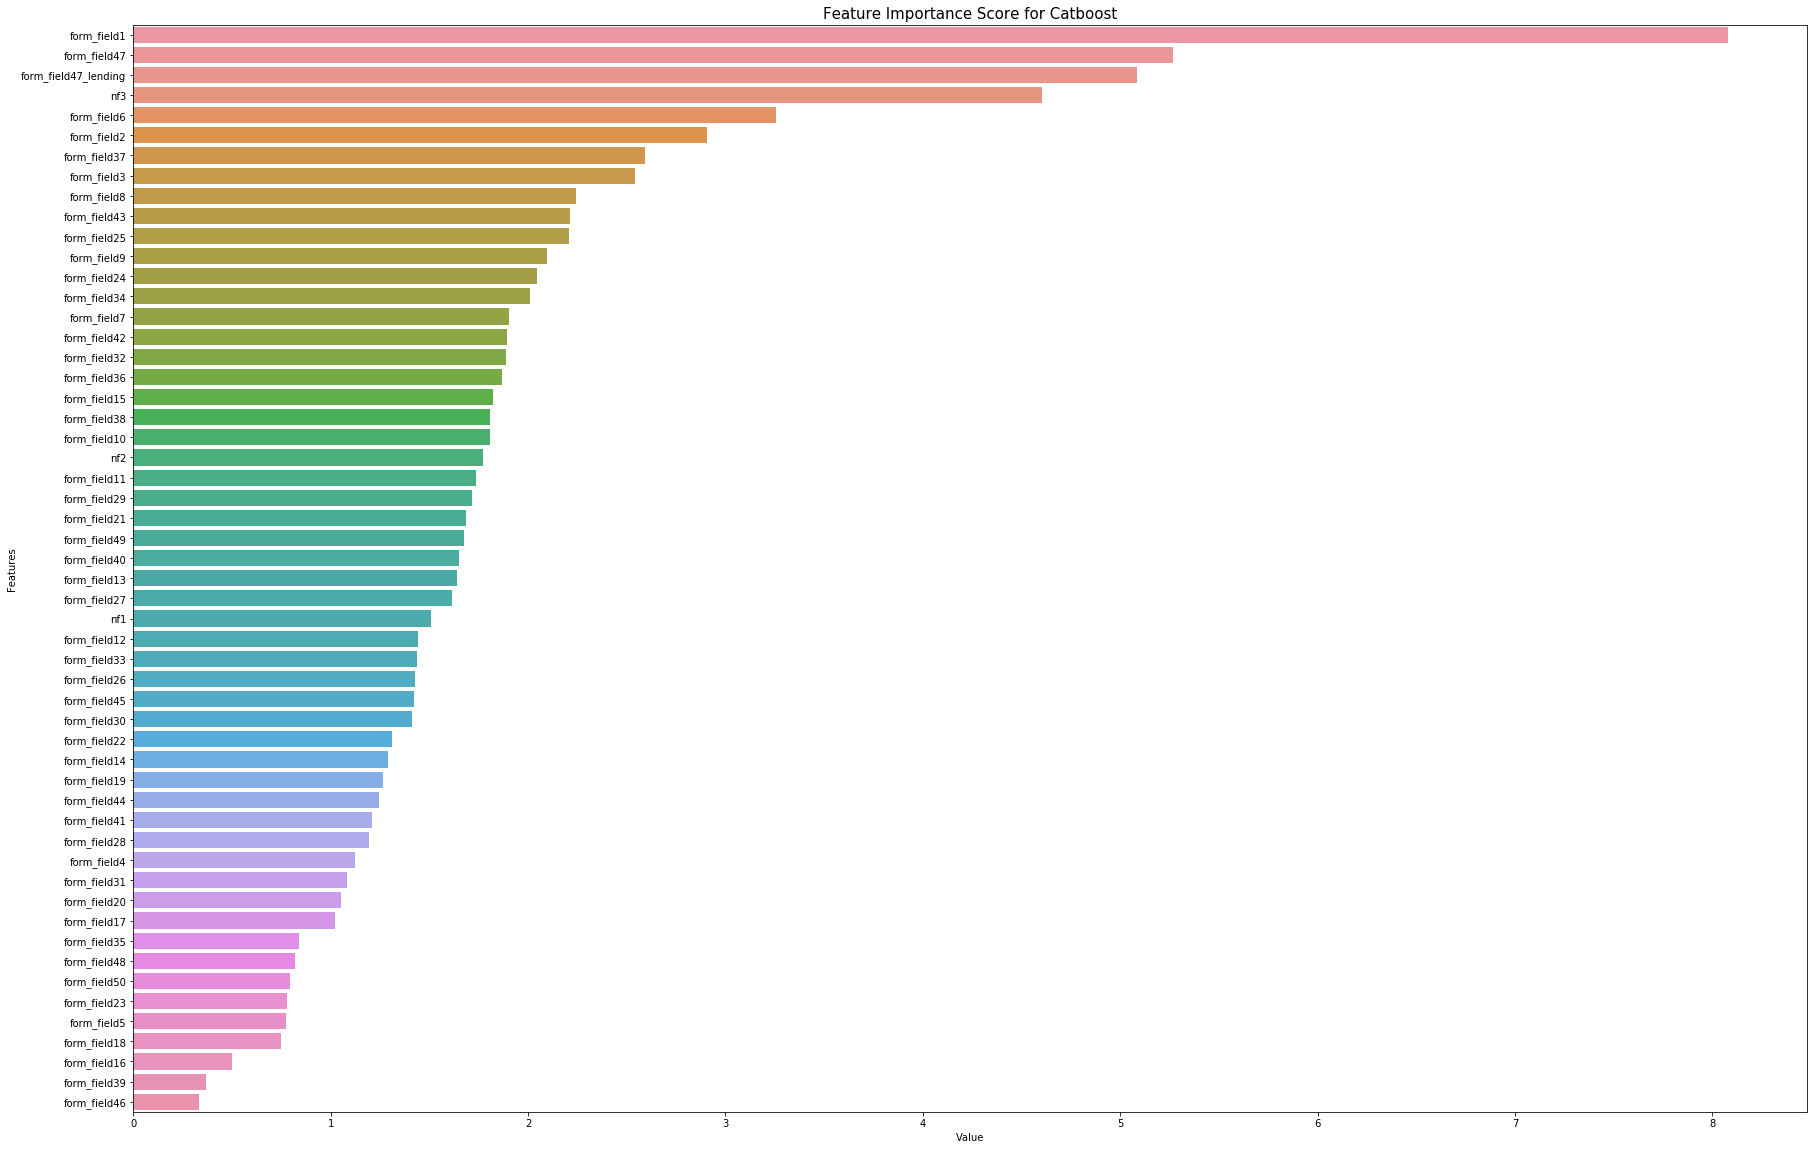

In [32]:
plot(cat_model, 'Catboost')

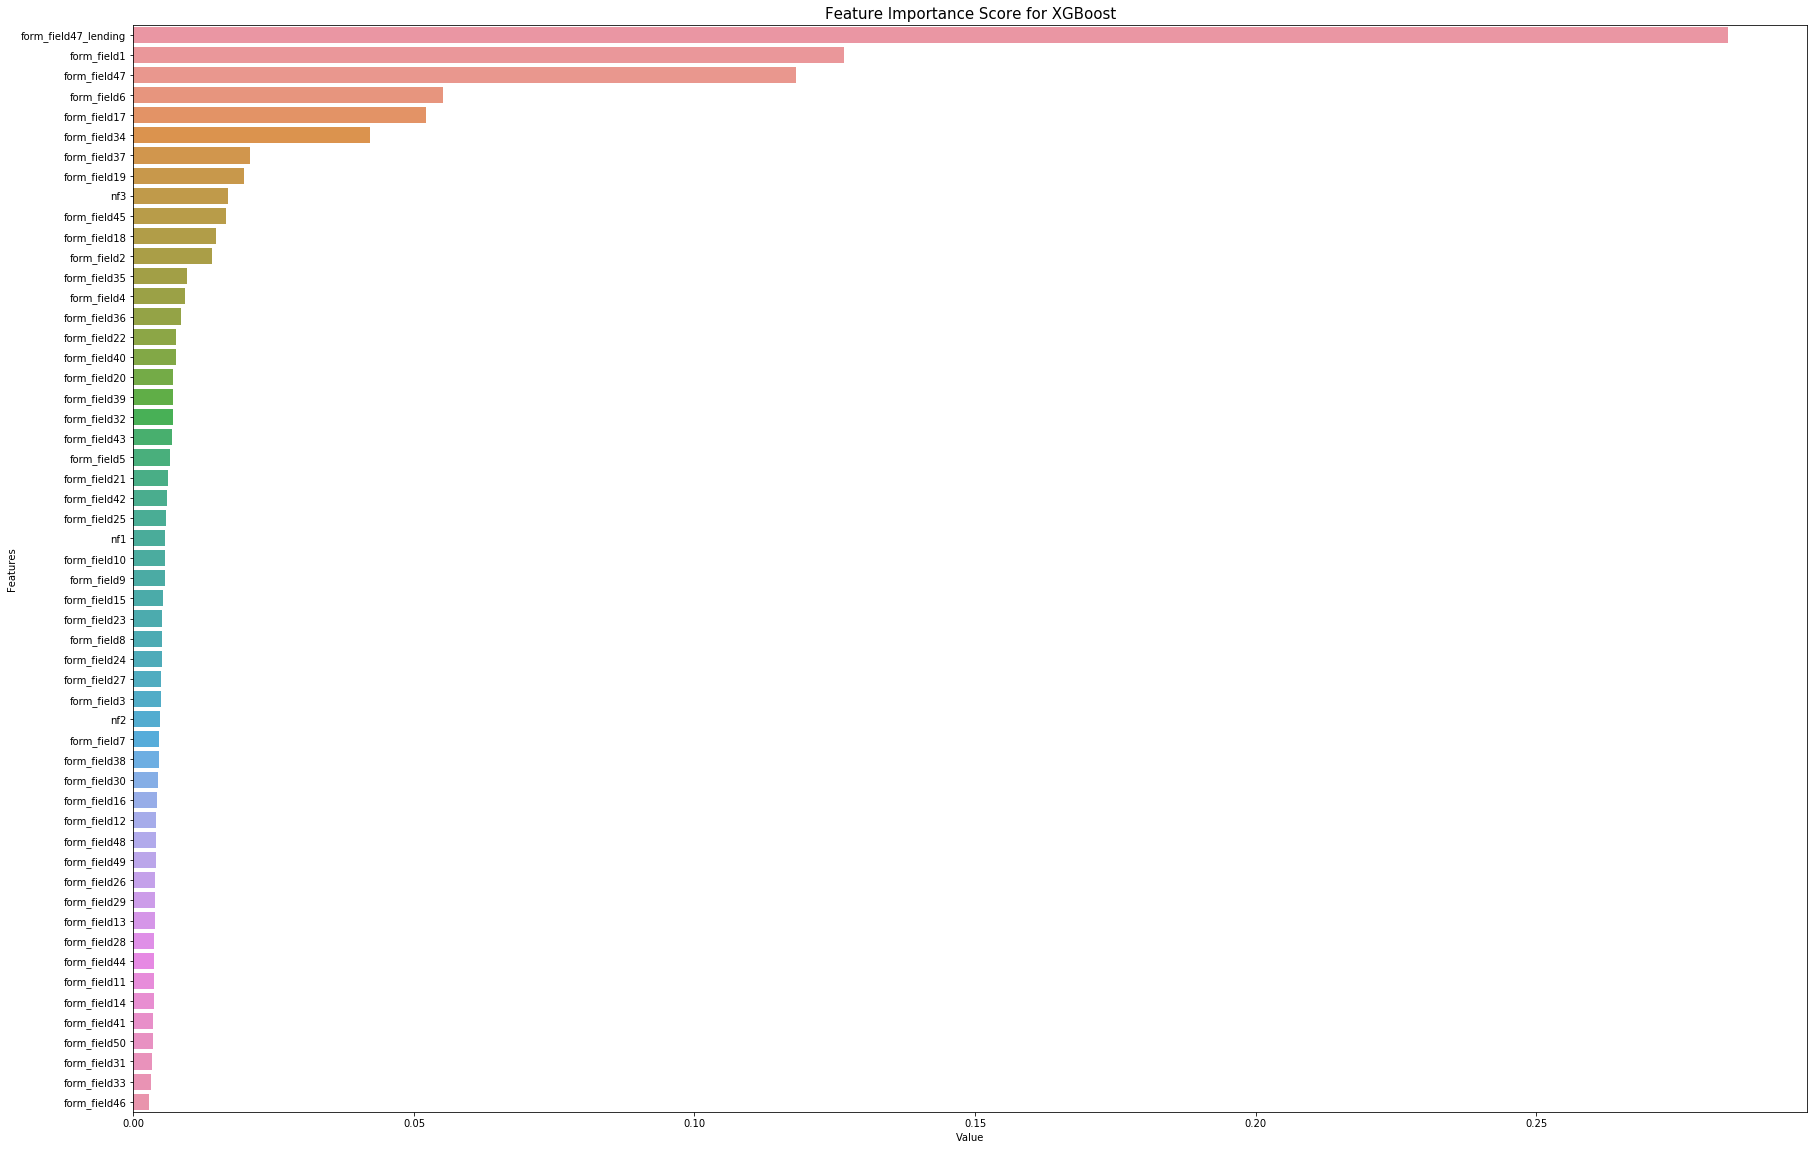

In [33]:
plot(xgb_model, 'XGBoost')

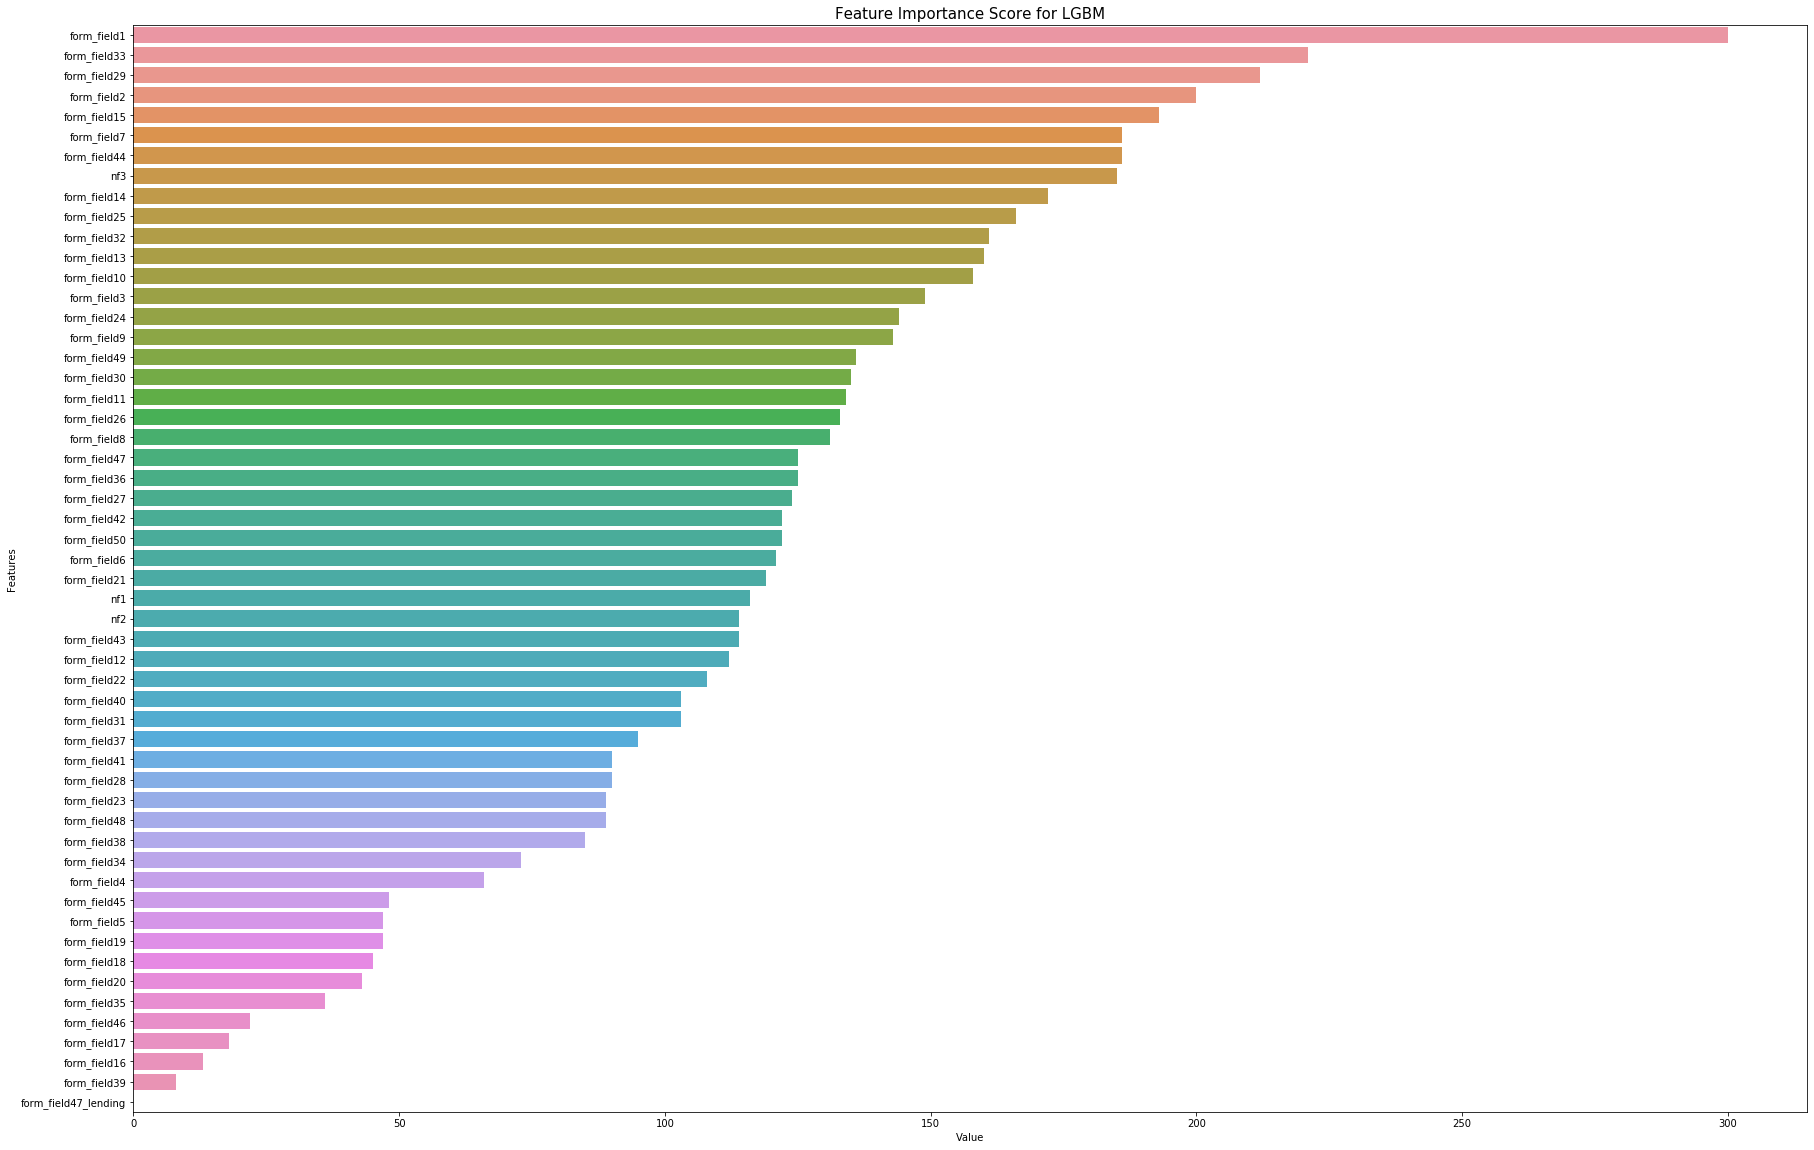

In [34]:
plot(lgb_model, 'LGBM')